# Evaluation - sDCG, Effort vs Effect, sRBP #

### Wichtige Hinweise ###
- Die Benennung der Logdateien ist aktuell "simulation-topic-user_strat.log". Sollte sich daran etwas ändern, müssten einige Stellen dementsprechend angepasst werden. Wenn sich die Simulationen/Usertypen/Suchstrategien ändern, muss nichts gemacht werden (Anmerkung: Um flexibler zu sein, wäre es vielleicht einfacher, vor "strat" auch ein "-" zu setzen. Es funktioniert aktuell nur alles, wenn die Query Strategie mit "doc2query" anfängt. Falls es dafür aber andere Angaben gibt/geben wird, müsste das nach aktuellem Stand (also mit "_") noch in "get_log_props" angepasst werden)
- Bei den "relevance judgements" muss der Pfad zu den qrels angepasst werden (Suche nach "Pfad")
- Der Pfad zu den Logs muss gegebenenfalls auch angepasst werden (s.o.)
- Für sDCG sind b = 2 und bq = 4 gesetzt (wie in der ursprünglichen Evaluation). Falls die Werte geändert werden sollen: sie befinden sich im Abschnitt 'sDCG' (b_sdcg und bq_sdcg)
- Für die Parameter von sRBP (b und p) werden aktuell mit der Methode von Lipani die besten Werte (basierend auf allen verfügbaren Logdaten) bestimmt und verwendet. Sie können im Abschnitt 'sRBP' aber natürlich auch anders gesetzt werden (b_srbp und p_srbp)
- Aktuell werden die Abbildungen nicht gespeichert. Falls das geändert werden soll, müssen nur überall die Zeilen mit "savefig" einkommentiert werden
- Um zu entscheiden, wie viele Querys in der Evaluation betrachtet werden sollen, gibt die Funktion "querynumber_min_max_avg" die minimale, maximale und durchschnittliche Anzahl der Queries in allen log_files aus. Momentan wird aufgrund der Vergleichbarkeit die minimale Anzahl verwendet. Wenn das geändert werden soll, einfach "querynumber" anpassen
- Aktuell werden die Themen 1 bis 50 in die Evaluation einbezogen. Falls das geändert werden soll, muss "topics_to_analyze" angepasst werden
- "levels" sollte nicht verändert werden (enthält alle potentiellen Evaluationslevel, hier also "User" und "Query Strategy", könnte um Modalitäten u.a. erweitert werden, wenn so etwas dazu kommt). c_level kann aber nach Belieben verändert werden (wenn in die Evaluation nicht alle Ausprägungen eines Levels einbezogen werden sollen, sondern nur eine/ein paar bestimmte)
- Weniger wichtig, eher eine Frage: Es war in der ursprünglichen Evaluation so gemacht, dass nur für Dokumente, die der User als relevant markiert hat, überprüft wurde, ob sie relevant sind. Und nur, wenn das der Fall ist, tragen sie zum Ergebnis bei. Ich habe es jetzt genau so gemacht, habe aber trotzdem eine Frage dazu: Geht es bei dieser doppelten Überprüfung darum, den genauen Wert zu bestimmen, da der ja (zumindest bei IWTR) 0, 1 oder 2 sein könnte? Falls nicht, wäre es dann nicht konsequenter, entweder alle Dokumente einzubeziehen, die der User betrachtet hat, unabhängig von der Einordnung, oder die Überprüfung wegzulassen? Aktuell kommen ja nur vom User als relevant markierte und zusätzlich als "korrekt" relevant beurteilte Dokumente ins Ergebnis. Wenn die Einschätzung des Users für die Evaluation zählt, müsste die Relevanz nicht nochmal überprüft werden. Falls die Relevanz der Dokumente betrachtet werden soll, weil der User die Dokumente womöglich unzuverlässig bewertet, sollten dann nicht auch die Dokumente betrachtet werden, die nicht als relevant eingestuft wurden, weil ja auch dabei ein Fehler passiert sein kann?

## Vorbereitung ##

In [28]:
!pip install --upgrade ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/b8/d4/ce436660098b2f456e2b8fdf76d4f33cbc3766c874c4aa2f772c7a5e943f/ipywidgets-8.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.7 from https://files.pythonhosted.org/packages/8e/d4/d31b12ac0b87e8cc9fdb6ea1eb6596de405eaaa2f25606aaa755d0eebbc0/widgetsnbextension-4.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.7 from https://files.pythonhosted.org/packages/74/5e/2475ac62faf2e342b2bf20b8d8e375f49400ecb38f52e4e0a7557eb1cedb/jupyterlab_widgets-3.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.9 MB/s eta 0:00:00a 0:00:01


In [1]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [2]:
# imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
from matplotlib import rcParams
import glob

from tqdm import tqdm_notebook
import sys
import re
import seaborn as sns 
sns.set_style('darkgrid')

In [3]:
def get_log_props(log_path):
    log_path = os.path.relpath(log_path, log_root_path)
    log_path = log_path.replace('_doc2query','-doc2query') # WICHTIG: Diese Stelle muss angepasst werden, falls es später noch mehr Strategien geben sollte, die nicht mit "doc2query" beginnen
    parts = log_path.split('-')
    if len(parts) > 2:
        sim = parts[0]
        topic = parts[1]
        user = parts[2]
        strat = parts[3].split('.')[0]

        return (sim, topic, user, strat)
    else:
        return 

log_root_path = "/workspace/sims/output/" # Pfad; Anpassen, falls nötig
#load all logs
log_files = glob.glob(f"{log_root_path}*.log")

sims = set()
topics = set()
users = set()
strats = set()

log_cnt = 0

log_df = pd.DataFrame(columns=['Simulation', 'User', 'Strat', 'Topics'])

for path in log_files:
    res = get_log_props(path)
    if res:
        log_cnt +=1
        sim, topic, user, strat = res
        topics.add(topic)
        users.add(user)
        strats.add(strat)
        sims.add(sim)

        row = {'Simulation' : sim, 'User': user, 'Strat' : strat, 'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])


print(f"number of log files: {log_cnt}")
print(f"topics: {sorted(topics, key=lambda x: int(x))}")
print(f"users: {users}")
print(f"strats: {strats}")
print(f"simulations: {sims}")

log_df.groupby(['Simulation', 'User', 'Strat'])['Topics'].agg(lambda x: len(x)).reset_index()


number of log files: 10
topics: ['41', '42', '43', '44', '45', '46', '47', '48', '49', '50']
users: {'fixeddepthuser10'}
strats: {'doc2query_nofeedback'}
simulations: {'sim_wapo_bm25'}


,Simulation,User,Strat,Topics
0,sim_wapo_bm25,fixeddepthuser10,doc2query_nofeedback,10


In [4]:
#Relevance judgements & querynumber

# Relevance judgements
def relevance_judgements(qrels_path):
    qrels = {}
    with open(qrels_path) as f_in:
        for line in f_in.readlines():
            parts = line.split(' ')
            qrels[(parts[0],parts[2])] = parts[3]
    return qrels

# querynumber_min_max_avg(log_files): returns the minimum, maximum, and average number of queries in "log_files" (and can be used to decide how many queries should be considered for the evaluation)
def querynumber_min_max_avg(log_files):
    minq = 0
    maxq = 0
    sumq = 0
    count = 0
    for path in log_files:
        count += 1
        currentq = 0
        with open(path) as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    currentq += 1
        if currentq < minq or minq == 0:
            minq = currentq
        if currentq > maxq:
            maxq = currentq
        sumq += currentq
    avgq = sumq/count

    return [minq, maxq, round(avgq)]

In [5]:
topics_to_analyze = range(1,51)

# evaluation levels
levels = [users, strats]

# fixed values for other levels (optional; can be more than one)
c_users = {'query_type':['doc2query_nofeedback']}
c_strats = {'user':['fixeddepthuser10']}

fixed = [c_users, c_strats]

# Relevance judgements
qrels = relevance_judgements('/workspace/data/wapo/wapo_qrels') # (Ich hatte die echten qrels nicht, daher das "fake" im Namen) # Pfad anpassen

# Evaluation
#querynumber: How many queries per session will be considered in the evaluation
querynumber = querynumber_min_max_avg(log_files)[0] # 0: minimum number of queries in all log files, 1: maximum number of queries in all log files, 2: average number of queries (rounded) in all log files


## Allgemeine Hilfsfunktionen ##

In [6]:
# levelname(level): level name as string

# Gibt den Namen eines Evaluationslevels zurück (Überschrift für die Grafiken & Dateiname beim Speichern der Grafiken)

def levelname(level):
    if level == users:
        evaluation_level = 'Users'
    elif level == strats:
        evaluation_level = 'Query Strategies'
    else:
        evaluation_level = 'NONAME'

    return evaluation_level

In [7]:
# fixed_combinations(...): combinations that are suitable for the evaluation

# Gibt alle Kombinationen von Levelausprägungen an, die es für jede Ausprägung des Evaluationslevels gibt, mit (teilweise) festgesetzten Werten.
# So werden beispielsweise bei der Evaluation der Query-Strategie nur die User-Typen einbezogen, für die es log-Dateien mit allen möglichen Query-Strategien gibt

def fixed_combinations(fixed_list, level_index, sim):
    fixed_list.remove(levels[level_index])
    combinations = [p for p in itertools.product(*fixed_list)]
    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()] # falls es Ausprägungen des zu evaluierenden Levels nicht in der betrachteten Simulation gibt
    combis = []
    for combination in combinations:
        p = True
        for lev in existing_levels:
            cl = list(combination)
            cl.insert(level_index, lev)
            user = cl[0]
            query_type = cl[1]
            if not os.path.isfile(log_root_path + sim + "-" + str(topics_to_analyze[0]) + "-" + user + "_" + query_type + ".log"):
                p = False
        if p == True:
            for lev in existing_levels:
                x = list(combination)
                x.insert(level_index, lev)
                combis.append(x)

    return combis

# Es wird vorausgesetzt, dass es die logs zu allen Themen gibt (Überprüfung nur für das erste Thema)

In [8]:
# sim_files(...): returns all files that belong to a specific simulation
def sim_files(sim, log_files):
    for l in log_files:
        simfiles = [l for l in log_files if re.split(r'-|\\|/',l.split('-')[0])[-1] == sim]
    return simfiles


In [9]:
# Plots

# figure size in inches
rcParams['figure.figsize'] = 4,4

def dfl_sdcg(level, level_eval_all):
    df_l = {}
    for l in level:
        l_df = pd.DataFrame.from_dict(level_eval_all[l], orient="index").stack().to_frame()
        l_df = pd.DataFrame(l_df[0].values.tolist(), index=l_df.index).reset_index(names=['topic', 'query'])
        l_df = l_df.rename(columns={0: 'gain'})
        l_df = l_df[l_df.apply(lambda row: row['query'] <=querynumber, axis=1)]
        df_l[l] = l_df

    return df_l

def dfl_effeff(level, level_eval_all):
    df_l = {}

    for l in level:
        l_df = pd.DataFrame.from_dict(level_eval_all[l], orient="index").stack().to_frame()
        l_df = pd.DataFrame(l_df[0].values.tolist(), index=l_df.index).reset_index(names=['topic', 'cost'])
        l_df = l_df.rename(columns={0: 'gain'})
        l_df = l_df[l_df.apply(lambda row: row['cost'] <=10000, axis=1)]
        df_l[l] = l_df

    return df_l

def dfl_srbp(level, level_eval_all):
    df_l = {}

    for l in level:
        l_df = pd.DataFrame.from_dict(level_eval_all[l], orient="index").stack().to_frame()
        l_df = pd.DataFrame(l_df[0].values.tolist(), index=l_df.index).reset_index(names=['topic', 'query'])
        l_df = l_df.rename(columns={0: 'gain'})
        l_df = l_df[l_df.apply(lambda row: row['query'] <=querynumber, axis=1)]
        df_l[l] = l_df

    return df_l

def lineplot_sdcg(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_sdcg(level, level_eval_all)

    for l in level:
        sns.lineplot(data=df_l[l], x='query', y='gain', label=l, ax = ax)


def lineplot_effeff(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_effeff(level, level_eval_all)

    for l in level:
        sns.lineplot(data=df_l[l], x='cost', y='gain', label=l, ax = ax)



def lineplot_srbp(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_srbp(level, level_eval_all)

    for l in level:
        sns.lineplot(data=df_l[l], x='query', y='gain', label=l, ax=ax)



def histplots_sdcg(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_sdcg(level, level_eval_all)

    for l in level:
        sns.histplot(df_l[l], x ='gain', label = l, legend=True, ax = ax)

    ax.legend()


def histplots_effeff(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_effeff(level, level_eval_all)

    for l in level:
        sns.histplot(df_l[l], x ='gain', label = l, legend=True, ax=ax)

    ax.legend()


def histplots_srbp(level, evaluation_level, level_eval_all, ax):
    
    df_l = dfl_srbp(level, level_eval_all)

    for l in level:
        sns.histplot(df_l[l], x ='gain', label = l, legend=True, ax=ax)

    ax.legend()


## sDCG ##

In [10]:
# sDCG parameters
b_sdcg = 2
bq_sdcg = 4

In [11]:
def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b_sdcg))

    return _dcg

In [12]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    evaluation_level = levelname(level)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'user' in fixed_values.keys():
        fixed_l[0] = fixed_values['user']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']

    combinations = fixed_combinations(fixed_l, level_index, sim)
    
    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:

        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    user = combination[0]
                    query_type = combination[1]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + str(topic) + "-" + user + "_" + query_type + ".log"

                    with open(log_path) as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')
                                
                            if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':                             
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            if logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                                query_logs[query] = results

                    sdcg = {}
                    _sdcg = 0.0
                    for q, query in enumerate(query_logs.keys()):
                        results = query_logs.get(query)   
                        _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq_sdcg))
                        sdcg[q+1] = _sdcg
                            
                    sdcg_eval_combi[c] = sdcg
                    c += 1

            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()

    print('sDCG Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sDCG "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='sDCG', ax = ax1)
            #ax1.set_xlim([0, querynumber-1])
            #ax1.set_ylim(bottom = 0)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_sdcg(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_sdcg(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/sdcg.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [13]:
# Auswertung aller logfiles einer Simulation (die hier übergeben werden); OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def sDCG_all(sim, log_files):
    full_eval = {}
    sdcg_eval = {}
    
    allfiles = sim_files(sim, log_files)
    for f in allfiles:
        log_path = f
            
        query_logs = {}        
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

                if logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                    query_logs[query] = results

        sdcg = {}
        _sdcg = 0.0

        topic = log_path.split('-')[1]

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq_sdcg))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[f] = sdcg
    full_eval[0] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber].T.mean().to_dict()

    print('sDCG evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(allfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(allfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sDCG "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(sdcg_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/sdcg.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## Effort vs. Effect ##

In [14]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    evaluation_level = levelname(level)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'user' in fixed_values.keys():
        fixed_l[0] = fixed_values['user']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']

    combinations = fixed_combinations(fixed_l, level_index, sim)
    
    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    user = combination[0]
                    query_type = combination[1]

                    log_path = log_root_path + sim + "-" + str(topic) + "-" + user + "_" + query_type + ".log"

                    _gain = 0
                    gain = {}  

                    with open(log_path) as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                #if logs[1] == 'SNIPPET':
                                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    
    print('Effect vs. Effort evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("Effort vs Effect "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/effort_effect.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [35]:
# Auswertung aller logfiles einer Simulation; OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def effeff_all(sim, log_files):
    full_eval = {}
    gain_all = {}
    eval_all = {}
    
    allfiles = sim_files(sim, log_files)
    for f in allfiles:
        log_path = f
        topic = log_path.split('-')[1]
            
        _gain = 0
        gain = {}
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')  
                        if qrels.get((topic,result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain

        gain_all[f] = gain
    full_eval[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
    eval_all[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()

    print('Effort vs Effect evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(allfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(allfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("Effort vs Effect "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', legend=False, ax=ax1)
    #leave out for performance reasons

    #ax2 = fig.add_subplot(1,3,2)
    #eva_df = pd.DataFrame.from_dict(eval_all[0], orient="index").stack().to_frame()
    #eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','cost'])
    #eva_df = eva_df.rename(columns={0:'gain'})
    #eva_df = eva_df[eva_df.apply(lambda row: row['cost'] <= 10000, axis=1)]
    #sns.lineplot(data = eva_df, x='cost',y='gain', ax=ax2)
    #ax3 = fig.add_subplot(1,3,3)
    #sns.histplot(eva_df['gain'], ax= ax3)

    #plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/effort_effect.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## sRBP ##

In [16]:
# Aldo Lipani sRBP (https://github.com/aldolipani/sRBP/blob/master/main.ipynb)

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def session_based_measure(d, sessions):
    res = 0.0
    for session in sessions:
        n=0 # rank
        m=0 # reformulation
        for event in session:
            if event.startswith('q'):
                m=0
                n=0
            elif event == 'r':
                n=0
                m+=1
            elif event.endswith('-1'):
                res+= d(m, n)
                n+=1
            elif event != 'f':
                n+=1

        res/=len(sessions)

        return res
    
# sRBP for all sessions
def srbp(b, p, sessions):
    return (1-p)*session_based_measure(lambda m, n : d_srbp(b, p, m, n), sessions)
# 1 - p: normalization factor

In [17]:
# b_p_srbp(log_files): determine best b and p for sRBP based on the log data (using all log-files for overall value or a specific part for example for one simulation)
# the code is from Aldo Lipani (https://github.com/aldolipani/sRBP/blob/master/main.ipynb) and only slightly modified to fit the log-file format
# returns best_b, best_p
def b_p_srbp(log_files):

    max_reformulation = 0
    max_rank = 0

    # determine max reformulation and max rank
    for log_file in log_files:
        m = -1 # -1 statt 0, weil bei der ersten Query (also Erstformulierung, nicht NEUformulierung) schon der Wert erhöht wird; im Original (von Lipani) lässt sich die erste Query einer Session von den anderen unterscheiden
        n = 0
        with open(log_file) as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                    if m > max_reformulation:
                        max_reformulation = m
                if parts[1] == 'SNIPPET':
                    n += 1
                    if n > max_rank:
                        max_rank = n

            
    count = [[0] * max_rank for i in range(max_reformulation+1)]
    for log_file in log_files:
        m = -1 # s.o.
        n = 0
        with open(log_file) as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                if parts[1] == 'SNIPPET':
                    count[m][n] += 1
                    n += 1
            
    df = pd.DataFrame(count)
    df = df/df.values.sum()
    gt = df.values
    df.transpose()

    M = gt.shape[0]
    N = gt.shape[1]

    min_err = sys.float_info.max
    res = 100
    best_p = -1
    best_b = -1
    grid = {}

    def tse_srbp(b, p):
        norm = 0.0
        for i in range(M*N):
            norm += d_srbp(b, p, i//N, i%N)
        err = 0.0
        for i in range(M*N):
            err += (gt[i//N, i%N]-d_srbp(b, p, i//N, i%N)/norm)**2
        return err

    t = tqdm_notebook(np.linspace(0, 1, res+1), desc = "TSE: {:.4f}".format(min_err))
    for p_i, p in enumerate(t):

        grid[p_i] = []
        for b in np.linspace(0, 1, res+1):
            
            err = tse_srbp(b, p)
            
            grid[p_i].append(err)

            if err < min_err:
                min_err = err
                best_p = p
                best_b = b
                t.set_description("TSE: {:.4f}".format(min_err))

    grid = pd.DataFrame.from_dict(grid)

    srbp_best_b = best_b
    srbp_best_p = best_p

    print("b =", best_b, ", p =", best_p, ", TSE = {:.4f}".format(min_err))
    return best_b, best_p

In [18]:
!pip show tqdm 

Name: tqdm
Version: 4.66.1
Summary: Fast, Extensible Progress Meter
Home-page: 
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: /usr/local/lib/python3.8/site-packages
Requires: 
Required-by: gdown, huggingface-hub, ir-datasets, nltk, python-terrier, transformers


In [19]:
# sRBP parameters
#p_srbp = 0.8 # persistence parameter (Wahrscheinlichkeit, die Suche fortzusetzen)
#b_srbp = 0.6 # balance parameter (Balance zwischen "das nächste Element betrachten" und "die Query neu formulieren")
b_srbp, p_srbp = b_p_srbp(log_files) # b und p basierend auf den logfiles


/tmp/ipykernel_174670/111904108.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(np.linspace(0, 1, res+1), desc = "TSE: {:.4f}".format(min_err))


TSE: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540…

b = 0.99 , p = 1.0 , TSE = 0.0001


In [20]:
# sRBP value for one session (using discount function from Lipani)
def s_rbp(b, p, log_path, topic):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path) as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count; DOCUMENT is not relevant here because it is just repeated after SNIPPET
                n += 1
                                
            elif logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT': # add d_srbp value for relevant document to the result
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res+= d_srbp(b, p, m, n)

    return (1-p)*res, query_rbp # return sRBP for whole session, list of sRBP values after each query

In [21]:

def sRBP_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    evaluation_level = levelname(level)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'user' in fixed_values.keys():
        fixed_l[0] = fixed_values['user']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']

    combinations = fixed_combinations(fixed_l, level_index, sim)

    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    user = combination[0]
                    query_type = combination[1]
                
                    log_path = log_root_path + sim + "-" + str(topic) + "-" + user + "_" + query_type + ".log"

                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic)[1]
                            
                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    print('sRBP Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sRBP "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_srbp(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_srbp(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/srbp.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [22]:
# sRBP Wert für alle übergebenen logfiles (ohne auf Usertyp o.ä. einzugehen)
def sRBP_all(sim, log_files):

    full_eval = {}
    srbp_eval = {}
    
    allfiles = sim_files(sim, log_files)
    for f in allfiles:
        log_path = f
        
        topic = log_path.split('-')[1]

        srbp = s_rbp(b_srbp, p_srbp, log_path, topic)[1]

        srbp_eval[f] = srbp
    
    full_eval[0] = pd.DataFrame.from_dict(srbp_eval)[:querynumber].T.mean().to_dict()

    print('sRBP evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(allfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(allfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sRBP "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(srbp_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/srbp.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## Evaluation ##

In [23]:
# Gesamte Evaluation: Es werden alle Graphen gezeigt für jedes Evaluationslevel und jede Simulation (auf Levelebene und allgemein)
def full_evaluation():
    for sim in sims:
        print(sim)
        sDCG_all(sim, log_files) 
        effeff_all(sim, log_files)
        sRBP_all(sim, log_files)
        for level in levels:
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)

# ANMERKUNG: Wenn man (sDCG/effeff/sRBP)_all so verwendet wie hier und einfach alle Logdateien übergibt, kann das Ergebnis, sobald es mehrere Usertypen und Strategien gibt,
# natürlich sehr schwierig zu interpretieren und zu vergleichen sein. Man kann aber vorher die Logdateien herausfiltern, die man übergeben möchte, und sie dann gezielt auswerten.



In [24]:
# Gesamte Evaluation für eine ausgewählte Simulation
def sim_evaluation(sim):
    print(sim)
    for level in levels:
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
    sDCG_all(sim, log_files)
    effeff_all(sim, log_files)
    sRBP_all(sim, log_files)

In [30]:
c_strats

{'user': ['fixeddepthuser10']}

Effort vs Effect evaluation of all sim_wapo_bm25 files
number of sessions: 10
minimum / maximum / average queries per session: [116, 198, 166]


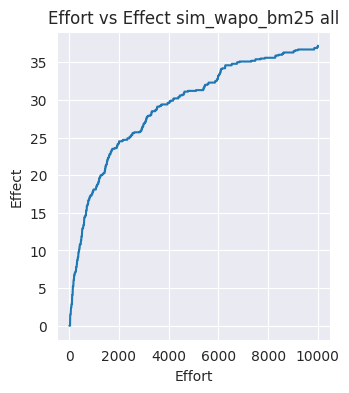

In [36]:
# Beispiele 
#sDCG_lev('wapo_sim', users, c_users, plot1=True, plot2=False, plot3=False)
#effeff_lev('sim_wapo_bm25', strats, c_strats, plot1=True, plot2=True, plot3=True)
#sRBP_lev('wapo_sim', users, c_users, plot1=True, plot2=False, plot3=False)
effeff_all(sim, log_files)
#full_evaluation()
#sim_evaluation('sim_wapo_bm25')